In [51]:
import pandas as pd
from glob import glob as gb
import os
from fuzzywuzzy import fuzz
import wikipedia
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup as bs
from fuzzywuzzy import process
import itertools
from fuzzywuzzy import fuzz
from collections import Counter
import random  
from datetime import datetime
import json 
import time
from dateutil.relativedelta import relativedelta

DATAPATH = "/media/ruben/Elements/PhD/data/hansard"
list_wikidata = [x for x in gb(DATAPATH + '/resources/wikidata-members/reformatted/*') if "-Q" in x]
dfm = pd.read_csv(DATAPATH + '/raw/pm/members_flattened.csv',sep='\t')
dfm = dfm.replace('9999-01-01',"na")
dfm['start'] = ["2030-01-01" if x == "9999-12-31" else x for x in dfm['start']]
dfm['end'] = ["2030-01-01" if x == "9999-12-31" else x for x in dfm['end']]
dfm['start'] = [datetime.strptime(x,'%Y-%m-%d') if x != "na" else "na" for x in dfm['start']]
dfm['end'] = [datetime.strptime(x,'%Y-%m-%d') if x != "na" else "na" for x in dfm['end']]

wikidata = pd.DataFrame()
for wikidata_ in list_wikidata:
    df_wkd = pd.read_csv(wikidata_,sep='\t')
    wikidata = wikidata.append(df_wkd)

wikidata['start'] = pd.to_datetime(wikidata['start'], format='%Y-%m-%d')
wikidata['end'] = pd.to_datetime(wikidata['end'], format='%Y-%m-%d')

const_dict = pd.read_csv(DATAPATH + "/resources/wikidata-membership-constituency-table.csv").fillna("nan")
const_dict = const_dict[const_dict['wikidata_const'] != "nan"]
const_dict = dict(zip(const_dict['mbs_const'],const_dict['wikidata_const']))

<AxesSubplot:xlabel='y'>

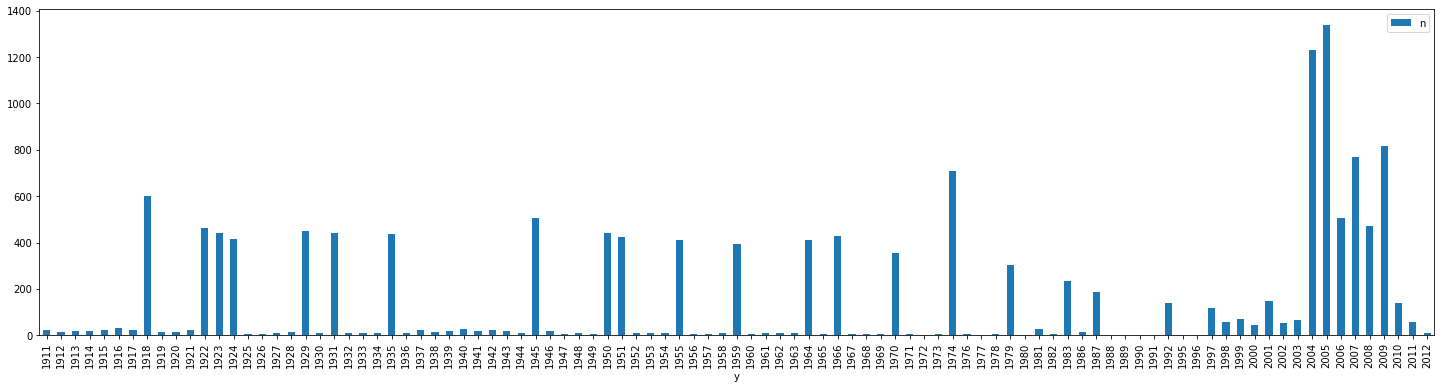

In [52]:
# Visualise number of memberships without party_name per year (based on start)
dfm['year'] = dfm['start'].astype(str).str[:4]
dfd = pd.DataFrame(Counter(dfm[dfm['party_name'] == "na"]['year']).items(),columns=['y','n']).sort_values('y').reset_index(drop=True).iloc[:-2,:]
dfd['y'] = dfd['y'].astype(int)
dfd = dfd[dfd['y'] > 1910]
dfd.plot.bar(x='y',y='n',figsize=(25,6))

In [53]:
matches_name = 0
matches_start_const_full = 0
matches_start_const_dict = 0
match_fuzzy = 0
queries = 0

for c,membership in tqdm(dfm.iterrows()):

    # Continue if party name is known, start date is unknown, start date and end date are unknown 
    if membership['party_name'] != "na" or str(membership['start']) == "na" or int(str(membership['start'])[:4]) <= 1917:# or int(str(membership['start'])[:4]) > 1936:
        continue 

    # Select candidates from wikidata. If end year is unknown, end year is set to start year + 10
    if membership['start'] != "na" and membership['end'] != "na":
        wiki_candidates = wikidata[(wikidata['start'] >= membership['start']) & (wikidata['end'] <= membership['end'])]
    if membership['start'] != "na" and membership['end'] == "na":
        wiki_candidates = wikidata[(wikidata['start'] >= membership['start']) & (wikidata['end'] <= membership['start'] + relativedelta(years=+10))]
    queries += 1
    if len(wiki_candidates) == 0:
        continue 
    candidate_names = list(set(wiki_candidates['mp']))

    # Check by Name:
    if len(wiki_candidates[wiki_candidates['mp'].isin([membership['full_name'],membership['comp_name'],membership['memb_name']])]) > 0:
        matches_name += 1
        m = wiki_candidates[wiki_candidates['mp'].isin([membership['full_name'],membership['comp_name'],membership['memb_name']])].reset_index(drop=True)
        dfm["party_name"][c] = m['party'][0]
        continue
    
    # Check by Constituency
    elif len(wiki_candidates[(wiki_candidates['start'] == membership['start']) & (wiki_candidates['constituency'] == membership['district'])]) > 0:
        m = wiki_candidates[(wiki_candidates['start'] == membership['start']) & (wiki_candidates['constituency'] == membership['district'])].reset_index(drop=True)
        dfm["party_name"][c] = m['party'][0]
        matches_start_const_full += 1
        continue

    # Check by fuzzy name matching (with confidence score of >= 90)
    elif process.extractOne(membership['full_name'],candidate_names)[1] >= 90:
        matched_name = process.extractOne(membership['full_name'],candidate_names)[0]
        m = wiki_candidates[(wiki_candidates['start'] == membership['start']) & (wiki_candidates['mp'] == matched_name)].reset_index(drop=True)
        if len(m) == 0:
            continue
        dfm["party_name"][c] = m['party'][0]
        match_fuzzy += 1
        continue 

    # Check by manually checked constituency dictionary
    elif membership['district'] in const_dict.keys():
        wikidata_const = const_dict[membership['district']]
        if len(wiki_candidates[(wiki_candidates['start'] == membership['start']) & (wiki_candidates['constituency'] == wikidata_const)]) > 0:
            m = wiki_candidates[(wiki_candidates['start'] == membership['start']) & (wiki_candidates['constituency'] == wikidata_const)].reset_index(drop=True)
            dfm["party_name"][c] = m['party'][0]
            matches_start_const_dict += 1
            continue 

print(f"\n{matches_name} matches by name \n",
      f"{matches_start_const_full} matches by start date and constituency\n",
      f"{matches_start_const_dict} matches by manually corrected constituency\n",
      f"{match_fuzzy} matches by fuzzy name matching (>= 90)\n",
      f"In total {queries} queries\n",
      f"Percentage of hits: {round((matches_name + matches_start_const_full + matches_start_const_dict + match_fuzzy) / queries,2)}%")

48451it [04:58, 162.13it/s]
4593 matches by name 
 3057 matches by start date and constituency
 177 matches by manually corrected constituency
 313 matches by fuzzy name matching (>= 90)
 In total 14660 queries
 Percentage of hits: 0.56%

